# Event-related Analysis

This example shows how to use **NeuroKit2** to extract epochs from data based on events localisation and its corresponding physiological signals.

In [6]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]  # Bigger images

## The Dataset

In this example, we will download the dataset, which contains 2.5 minutes of data recorded at a frequency of 100Hz (2.5 x 60 x 100 = 15000 data points).

In [7]:
# Get data
data = pd.read_csv("https://raw.githubusercontent.com/neuropsychology/NeuroKit/master/data/example_bio_100hz.csv")

This dataset correponds to the physiological signals of **one participant** during a typical cognitive experiment.

This experiment consisted in watching 4 images (stimuli), which we will refer to as **events**. Importantly, they were marked by a small black rectangle on the screen, which led to the photosensor signal to go down (and then up again after the image). This is what will allow us to retrieve the location of these events.

They were 2 types (the **condition**) of images that were shown to the participant: **"Negative"** vs. **"Neutral"** in terms of emotion. Each picture was presented for 3 seconds. The following list is the condition order.

In [8]:
condition_list = ["Negative", "Neutral", "Neutral", "Negative"]

## Find Events

The data was obtained using 4 channels, namely **EDA**, **ECG**, **RSP** and the **Photosensor**. The onsets of events are marked in the photosensor's signal.

These events can be localized and extracted using [events_find()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_find). 

*Note that you should also specify whether to select events that are higher or below the threshold using the `threshold_keep` argument.*

In [9]:
# Find events
events = nk.events_find(data["Photosensor"], threshold_keep='below', event_conditions=condition_list)
events

{'onset': array([ 1024,  4957,  9224, 12984]),
 'duration': array([300, 300, 300, 300]),
 'label': array(['1', '2', '3', '4'], dtype='<U11'),
 'condition': ['Negative', 'Neutral', 'Neutral', 'Negative']}

As we can see, `events_find()` returns a dict containing onsets and durations for each corresponding event, based on the label for event identifiers and each event condition. Each event here lasts for 300 data points (equivalent to 3 seconds sampled at 100Hz).

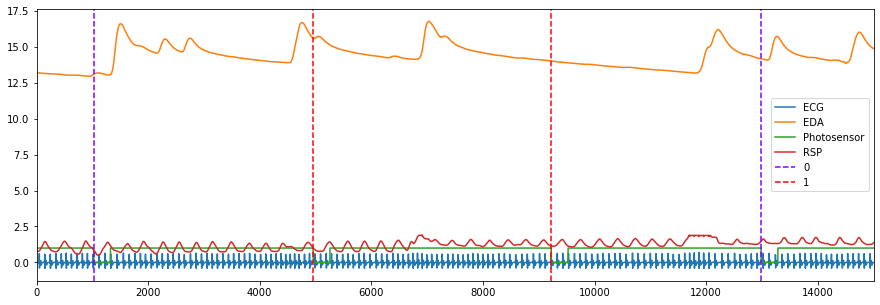

In [10]:
# Plot events
plot = nk.events_plot(events, data)

The output of [events_plot()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.events_plot) shows the corresponding events in the signal, with the blue dashed line representing a Negative event and red dashed line representing a Neutral event.

## Process the Signals

Now that we have the events location, we can go ahead and process the data.

Biosignals processing can be done quite easily using NeuroKit with the [bio_process()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.bio_process) function. Simply provide the appropriate biosignal channels and additional channels that you want to keep (for example, the photosensor), and `bio_process()` will take care of the rest. It will return a dataframe containing processed signals and a dictionary containing useful information.

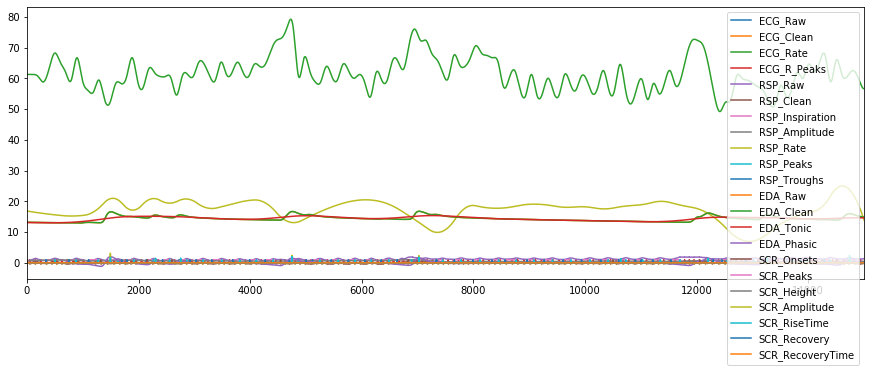

In [11]:
# Process the signal
df, info = nk.bio_process(ecg=data["ECG"], rsp=data["RSP"], eda=data["EDA"], sampling_rate=100)

# Visualize
df.plot()

## Create Epochs

We now have to transform this dataframe into **epochs**, i.e. segments (chunks) of data around the **events** using [epochs_create()](https://neurokit2.readthedocs.io/en/latest/functions.html#neurokit2.epochs_create). 

We set our epochs to start 1 second before the event onset and to last for 7 seconds (i.e., 700 data points since the signal is sampled at 100Hz). These are passed into the `epochs_start` and `epochs_duration` arguments, respectively. Our epochs will then cover the region from **-1 s** to **+6 s**.

In [12]:
# Build and plot epochs
epochs = nk.epochs_create(df, events, sampling_rate=100, epochs_start=-1, epochs_duration=7)

Let's plot some of the signals of the first epoch (and transform them to the same scale for visualization purposes). 

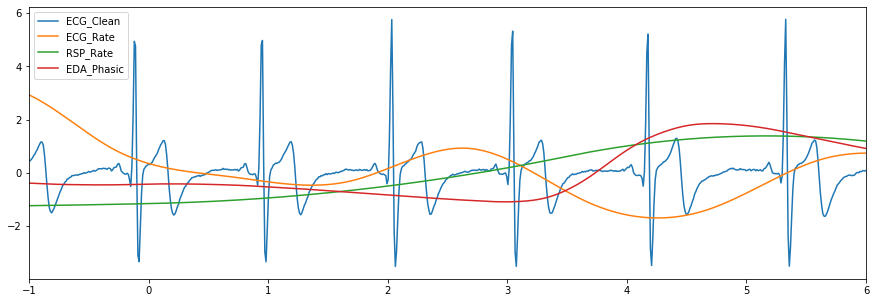

In [13]:
first_epoch = epochs["1"]  # Extract first epoch
first_epoch = first_epoch[['ECG_Clean', 'ECG_Rate', 'RSP_Rate', 'EDA_Phasic']]  # Select relevant columns
nk.standardize(first_epoch).plot()  # Plot scaled signals

## Extract Event Related Features

With this, we are able to compare how the physiological signals vary across the different events. We do this by **iterating through the epochs** and storing the results in a new dictionary, which is later converted into a dataframe, as shown below.



In [14]:
# Extract Event Related Features
df = {}  # Initialize an empty dict
for epoch_index in epochs:
    df[epoch_index] = {}  # Initialize an empty dict for the current epoch
    epoch = epochs[epoch_index]

    # ECG
    ecg_baseline = epoch["ECG_Rate"].loc[-100:0].mean()  # Baseline
    ecg_mean = epoch["ECG_Rate"].loc[0:400].mean()  # Maximum heart rate in the 0-4 seconds
    df[epoch_index]["ECG_Rate"] = ecg_mean - ecg_baseline  # Correct for baseline

    # EDA - SCR
    scr_max = epoch["SCR_Amplitude"].loc[0:600].max()  # Maximum SCR peak
    if np.isnan(scr_max):
        scr_max = 0  # If no SCR, consider the magnitude, i.e.  that the value is 0
    df[epoch_index]["SCR_Magnitude"] = scr_max

    # RSP
    rsp_baseline = epoch["RSP_Rate"].loc[-100:0].mean()  # Baseline
    rsp_rate = epoch["RSP_Rate"].loc[0:600].mean()
    df[epoch_index]["RSP_Rate"] = rsp_rate - rsp_baseline  # Correct for baseline


df = pd.DataFrame.from_dict(df, orient="index")  # Convert to a dataframe
df["Condition"] = condition_list  # Add the conditions
df  # Print DataFrame

,ECG_Rate,SCR_Magnitude,RSP_Rate,Condition
1,-5.636245,3.114808,3.035728,Negative
2,-0.838826,0.000000,2.937407,Neutral
3,3.631151,0.000000,-0.663905,Neutral
4,-3.988120,1.675922,2.846962,Negative


## Plot Event Related Features


You can now plot and compare how these features differ according to the event of interest.

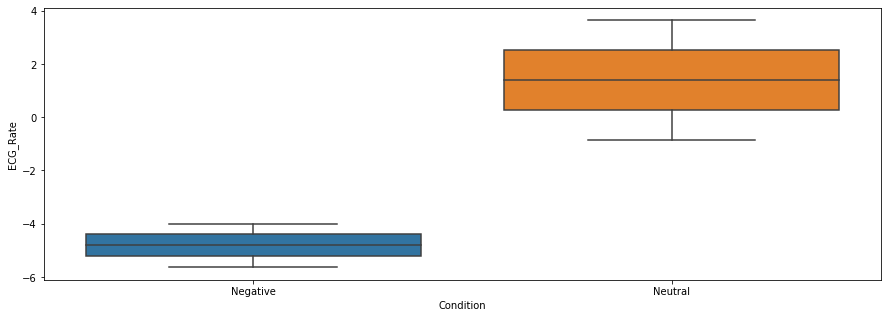

In [15]:
sns.boxplot(x="Condition", y="ECG_Rate", data=df)

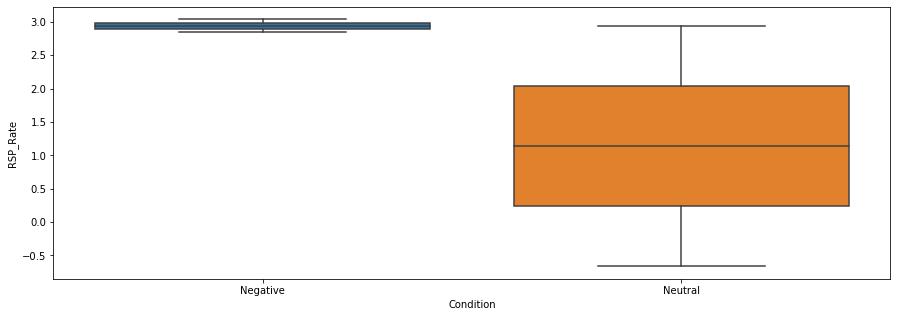

In [16]:
sns.boxplot(x="Condition", y="RSP_Rate", data=df)

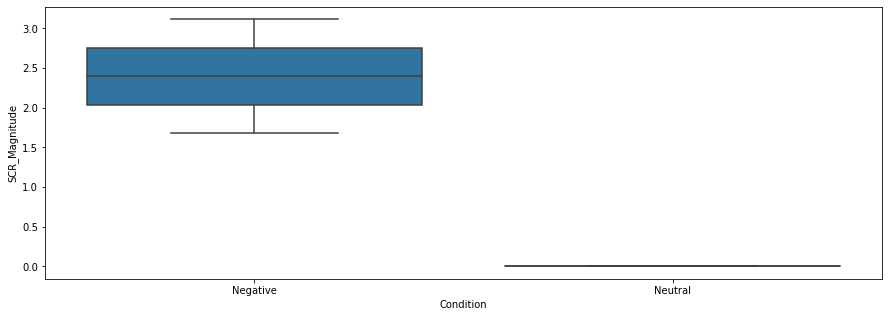

In [17]:
sns.boxplot(x="Condition", y="SCR_Magnitude", data=df)

As we can see, there seems to be a difference between the negative and the neutral pictures. Negative stimuli, as compared to neutral stimuli, were related to a stronger cardiac deceleration (i.e., higher heart rate variability), an accelerated breathing rate, and higher SCR magnitude.